In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import time
import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 5080
Memory: 17.09 GB


In [3]:
input_files = sorted(glob.glob('data/train/input_*.csv'))
output_files = sorted(glob.glob('data/train/output_*.csv'))

print(f"Input files: {len(input_files)}")
print(f"Output files: {len(output_files)}")

Input files: 18
Output files: 18


In [4]:
input_dfs = []
output_dfs = []

for input_file, output_file in zip(input_files[:5], output_files[:5]):
    input_dfs.append(pd.read_csv(input_file))
    output_dfs.append(pd.read_csv(output_file))

input_df = pd.concat(input_dfs, ignore_index=True)
output_df = pd.concat(output_dfs, ignore_index=True)

print(f"Input shape: {input_df.shape}")
print(f"Output shape: {output_df.shape}")

Input shape: (1399311, 23)
Output shape: (159814, 6)


In [5]:
merged_df = input_df.merge(
    output_df, 
    on=['game_id', 'play_id', 'nfl_id'],
    suffixes=('_input', '_output')
)

print(f"Merged shape: {merged_df.shape}")

Merged shape: (4634163, 26)


In [6]:
feature_cols = ['x_input', 'y_input', 's', 'a', 'dir', 'o']
target_cols = ['x_output', 'y_output']

X = merged_df[feature_cols].fillna(0)
y = merged_df[target_cols].fillna(0)

print(f"Features: {X.shape}")
print(f"Targets: {y.shape}")

Features: (4634163, 6)
Targets: (4634163, 2)


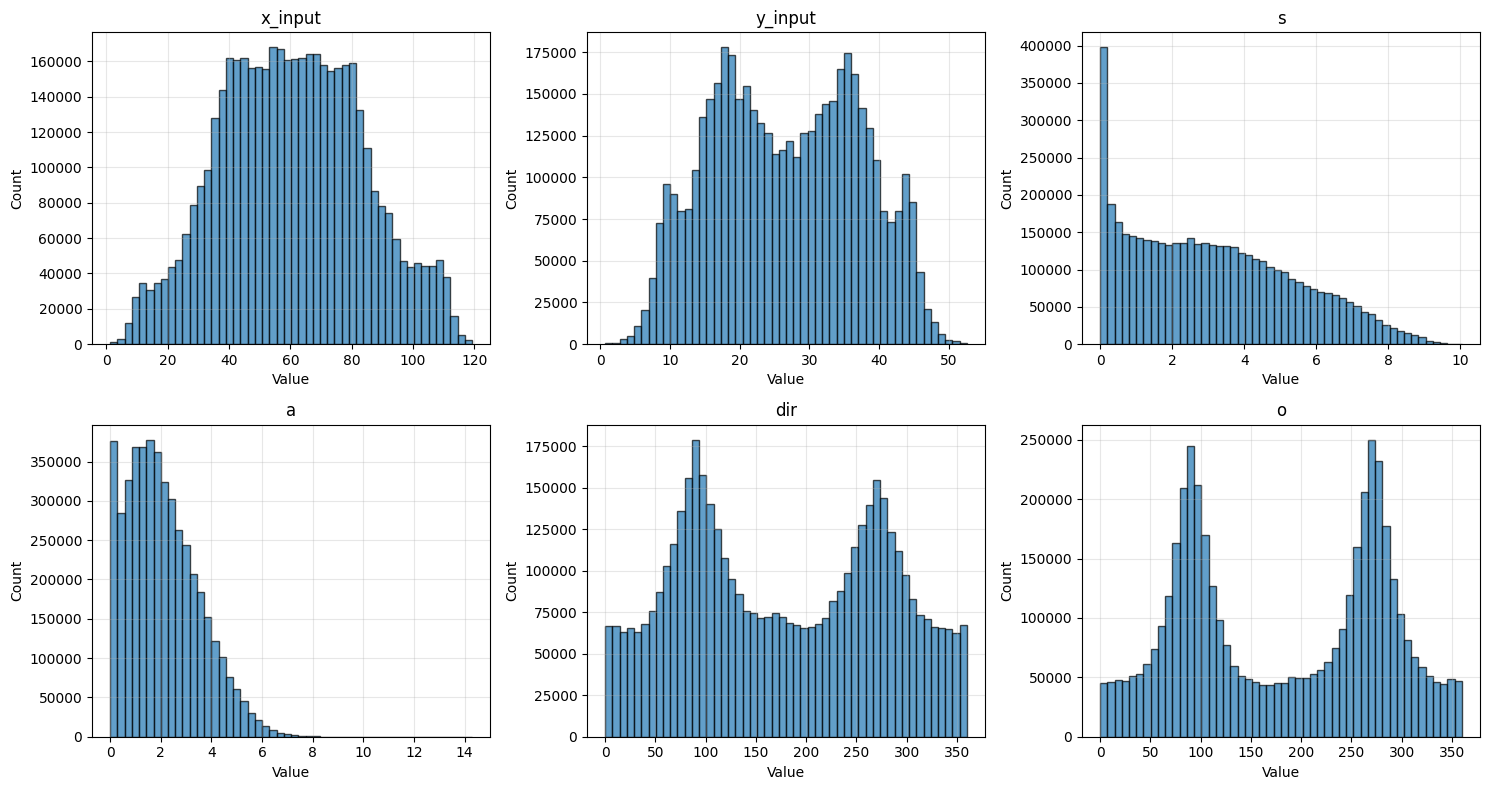

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for idx, col in enumerate(feature_cols):
    ax = axes[idx // 3, idx % 3]
    ax.hist(X[col], bins=50, edgecolor='black', alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

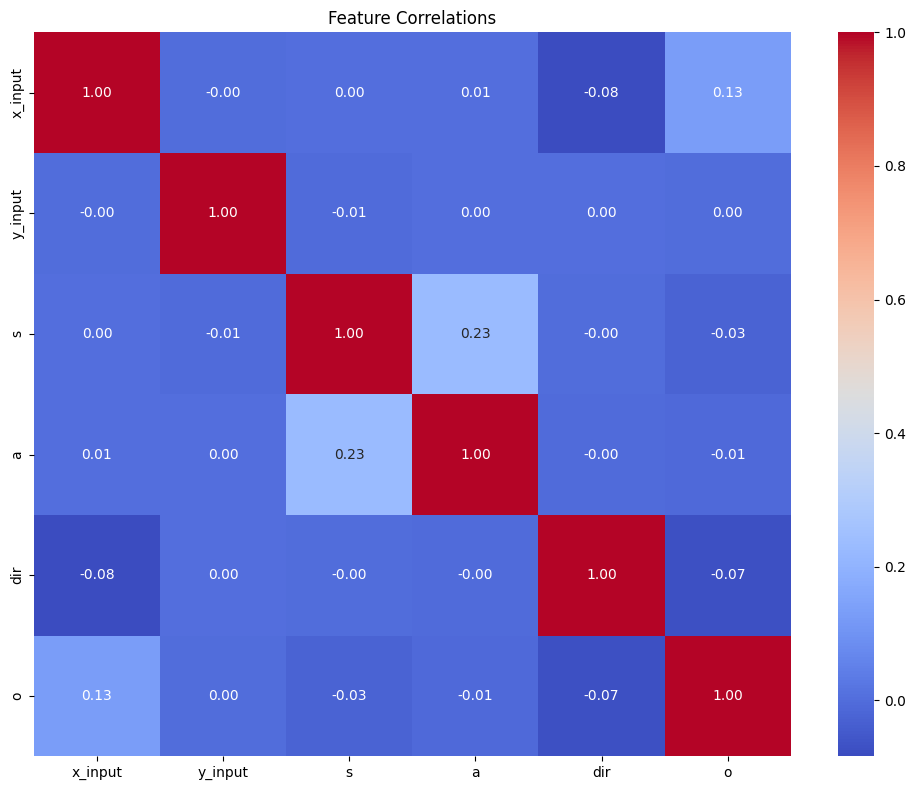

In [8]:
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlations')
plt.tight_layout()
plt.show()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train: {X_train.shape}")
print(f"Test: {X_test.shape}")

Train: (3707330, 6)
Test: (926833, 6)


In [10]:
# Preprocessing: scale features and convert to PyTorch tensors
from sklearn.preprocessing import StandardScaler
from joblib import dump
import torch
# Reproducibility
seed = 42
import numpy as np
np.random.seed(seed)
torch.manual_seed(seed)

# Fit scaler on training features and transform both train/test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler for inference later
dump(scaler, 'scaler.joblib')

# Convert to float32 numpy arrays
X_train_arr = np.asarray(X_train_scaled, dtype=np.float32)
X_test_arr = np.asarray(X_test_scaled, dtype=np.float32)
y_train_arr = np.asarray(y_train.values, dtype=np.float32)
y_test_arr = np.asarray(y_test.values, dtype=np.float32)

# Reshape features to (N, C, L) for Conv1d. We'll use 1 channel and sequence length = number of features
seq_len = X_train_arr.shape[1]
X_train_t = torch.from_numpy(X_train_arr).unsqueeze(1)  # shape (N,1,seq_len)
X_test_t = torch.from_numpy(X_test_arr).unsqueeze(1)
y_train_t = torch.from_numpy(y_train_arr)
y_test_t = torch.from_numpy(y_test_arr)

print('Prepared tensors:', X_train_t.shape, y_train_t.shape, X_test_t.shape, y_test_t.shape)

Prepared tensors: torch.Size([3707330, 1, 6]) torch.Size([3707330, 2]) torch.Size([926833, 1, 6]) torch.Size([926833, 2])


In [11]:
# Create TensorDatasets and DataLoaders
from torch.utils.data import TensorDataset, DataLoader
batch_size = 256
train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
valid_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

print('Batches (train,valid):', len(train_loader), len(valid_loader))

Batches (train,valid): 14482 3621


In [12]:
# Define 1D CNN model for regression (output dim = 2)
import torch.nn as nn

class CNN1D(nn.Module):
    def __init__(self, in_channels=1, out_dim=2):
        super().__init__()
        # Small feature extractor suitable for very short sequences (seq_len ~ 6)
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.AdaptiveAvgPool1d(1)  # output shape (batch, 32, 1)
        )
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 1, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, out_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.regressor(x)
        return x

# Instantiate model and move to device
model = CNN1D(in_channels=1, out_dim=y_train_t.shape[1]).to(device)
print(model)

CNN1D(
  (encoder): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): ReLU()
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): AdaptiveAvgPool1d(output_size=1)
  )
  (regressor): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [13]:
# Training loop with simple validation and checkpointing (records history)
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

n_epochs = 50
best_val_loss = float('inf')
save_path = 'cnn1d_model.pth'

# History lists to plot later
train_history = []
val_history = []

for epoch in range(1, n_epochs + 1):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # Validation
    model.eval()
    val_losses = []
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for xb, yb in valid_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_losses.append(loss.item())
            all_preds.append(preds.cpu().numpy())
            all_targets.append(yb.cpu().numpy())

    avg_train = np.mean(train_losses) if len(train_losses) > 0 else float('nan')
    avg_val = np.mean(val_losses) if len(val_losses) > 0 else float('nan')

    # record history
    train_history.append(avg_train)
    val_history.append(avg_val)

    all_preds_arr = np.vstack(all_preds) if len(all_preds) > 0 else np.empty((0, y_train_t.shape[1]))
    all_t_arr = np.vstack(all_targets) if len(all_targets) > 0 else np.empty((0, y_train_t.shape[1]))
    if all_preds_arr.shape[0] > 0:
        val_mse = mean_squared_error(all_t_arr, all_preds_arr)
        val_r2 = r2_score(all_t_arr, all_preds_arr)
    else:
        val_mse = float('nan')
        val_r2 = float('nan')

    print(f'Epoch {epoch}/{n_epochs}  TrainLoss={avg_train:.6f}  ValLoss={avg_val:.6f}  ValMSE={val_mse:.6f}  ValR2={val_r2:.4f}')

    # Checkpoint best model
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        torch.save({'model_state_dict': model.state_dict(), 'scaler':'scaler.joblib', 'epoch': epoch}, save_path)
        print('  Saved best model')

print('Training finished')

Epoch 1/50  TrainLoss=86.793918  ValLoss=41.945477  ValMSE=41.920868  ValR2=0.8630
  Saved best model
Epoch 2/50  TrainLoss=56.490046  ValLoss=41.485696  ValMSE=41.461689  ValR2=0.8642
  Saved best model
Epoch 3/50  TrainLoss=55.211059  ValLoss=41.504891  ValMSE=41.480377  ValR2=0.8646
Epoch 4/50  TrainLoss=54.194137  ValLoss=41.004516  ValMSE=40.980667  ValR2=0.8659
  Saved best model
Epoch 5/50  TrainLoss=53.417138  ValLoss=40.915610  ValMSE=40.891914  ValR2=0.8660
  Saved best model
Epoch 6/50  TrainLoss=52.695422  ValLoss=40.904572  ValMSE=40.881340  ValR2=0.8660
  Saved best model
Epoch 7/50  TrainLoss=52.143561  ValLoss=40.741566  ValMSE=40.717888  ValR2=0.8665
  Saved best model
Epoch 8/50  TrainLoss=51.688245  ValLoss=40.799426  ValMSE=40.775879  ValR2=0.8663
Epoch 9/50  TrainLoss=51.308723  ValLoss=40.720439  ValMSE=40.697540  ValR2=0.8662
  Saved best model
Epoch 10/50  TrainLoss=50.893608  ValLoss=40.782811  ValMSE=40.758404  ValR2=0.8662
Epoch 11/50  TrainLoss=50.529129  Va

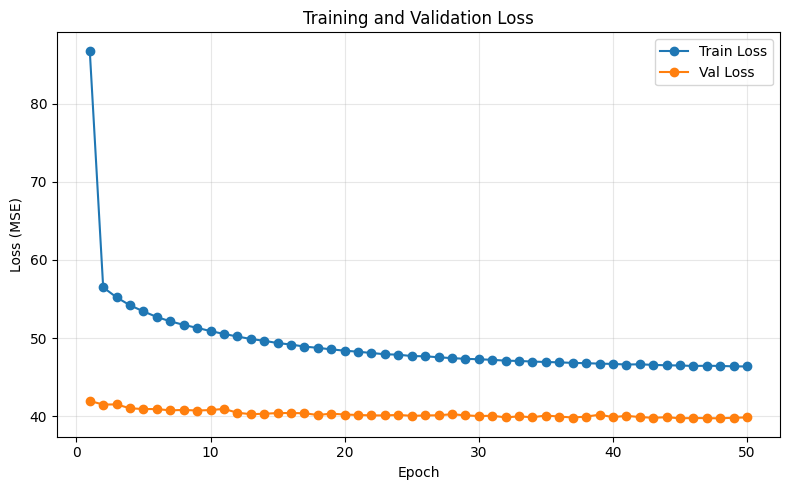

In [14]:
# Plot training and validation loss history
import matplotlib.pyplot as plt

# train_history and val_history are populated by the training cell
epochs = range(1, len(train_history) + 1)
plt.figure(figsize=(8,5))
plt.plot(epochs, train_history, label='Train Loss', marker='o')
plt.plot(epochs, val_history, label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
# Load best model and evaluate on test set (full test)
ckpt = torch.load('cnn1d_model.pth', map_location=device)
model.load_state_dict(ckpt['model_state_dict'])
model.to(device)
model.eval()

all_preds = []
all_targets = []
with torch.no_grad():
    for xb, yb in valid_loader:
        xb = xb.to(device)
        preds = model(xb).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.numpy())





In [16]:
all_preds_arr = np.vstack(all_preds)
all_targets_arr = np.vstack(all_targets)
mse = mean_squared_error(all_targets_arr, all_preds_arr)
r2 = r2_score(all_targets_arr, all_preds_arr)
print(f'Test MSE: {mse:.6f}, Test R2: {r2:.4f}')

Test MSE: 39.697033, Test R2: 0.8691


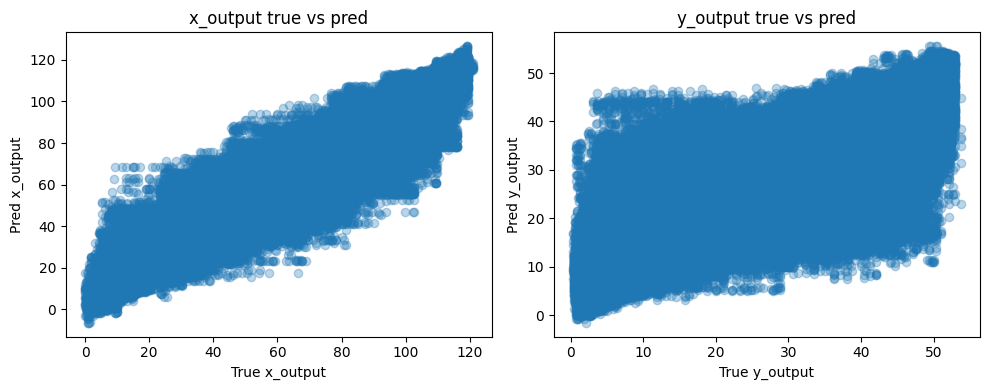

In [17]:
# Quick scatter plot of true vs predicted for output dims

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(all_targets_arr[:,0], all_preds_arr[:,0], alpha=0.3)
plt.xlabel('True x_output')
plt.ylabel('Pred x_output')
plt.title('x_output true vs pred')
plt.subplot(1,2,2)
plt.scatter(all_targets_arr[:,1], all_preds_arr[:,1], alpha=0.3)
plt.xlabel('True y_output')
plt.ylabel('Pred y_output')
plt.title('y_output true vs pred')
plt.tight_layout()
plt.show()